In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
from astropy import constants as const
from matplotlib import colors
PLOT_PARAMS()
import thejoker as tj

from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

07_29_25


In [2]:
df_rich = pd.read_pickle('../../lithium/data/gfinal_rich.pkl')

In [3]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [4]:
galah_vac = Table.read('../../lithium/data/GALAH_DR3_VAC_ages_v2.fits').to_pandas()

In [5]:
rv_df = pd.read_csv('comb_rvs.csv')

In [6]:
binary_list_113 = 1, 4, 5, 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = 5, 6, 7, 23 #13 removed because of dipper star

In [7]:
def load_samples(df0,program,binary_list):
    stat_dict = {}        
    version = 1
    
    df = df0[df0.program==program]
    
    dtemp = {'RG_id':[],
             'P16':[], 'P50':[], 'P84':[],
             'e16':[], 'e50':[], 'e84':[],
             'K16':[], 'K50':[], 'K84':[] }
    
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)
        
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        Ks = mcmc_samples['K'].value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['P16'].append(np.percentile(Ps, 16))
        dtemp['P50'].append(np.percentile(Ps, 50))
        dtemp['P84'].append(np.percentile(Ps, 84))
        
        dtemp['e16'].append(np.percentile(es, 16))
        dtemp['e50'].append(np.percentile(es, 50))
        dtemp['e84'].append(np.percentile(es, 84))
        
        dtemp['K16'].append(np.percentile(Ks, 16))
        dtemp['K50'].append(np.percentile(Ks, 50))
        dtemp['K84'].append(np.percentile(Ks, 84))
    
    dtemp = pd.DataFrame(dtemp)
    
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

temp1 = load_samples(rv_df, 112, binary_list_112)
temp2 = load_samples(rv_df, 113, binary_list_113)


In [8]:
table1 = pd.concat([temp1, temp2])

# get mass from galah
table1 = pd.merge(table1, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep','radius_bstep','e_radius_bstep']], left_on='sobject_id', right_on='sobject_id')

table1.loc[(table1.RG_id==13) & (table1.program==112),'m_act_bstep']    = 1.070 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'radius_bstep']   = 2.0731 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'e_m_act_bstep']  = 0.04 #from Gaia DR3 FLAME
table1.loc[(table1.RG_id==13) & (table1.program==112),'e_radius_bstep'] = 0.05 #from Gaia DR3 FLAME


In [9]:
def semi_major_axis(M1, M2, P):
    '''
    M1 : in solar masses
    P : in days
    M2 : in Mjup
    
    @return a: m
    
    '''
    G = const.G
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    P = (P*u.day).to(u.second)
    a = (G*M*P**2/(4*np.pi**2))**(1./3)
    
    return a


In [10]:
def v_max(df):
    '''
    M1 in solar units
    M2 in Mjup units
    a in AU
    
    return v_max in km/s
    
    '''
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e = df.a50.to_numpy(), df.e50.to_numpy()
    
    M1 = (M1*u.Msun).to(u.kg)
    M2 = (M2*u.Mjup).to(u.kg)
    M = (M1+M2)
    a = (a*u.au).to(u.m)
    M = (M1+M2)
    G = const.G

    v = ((G*M/a) * (2./(1-e) - 1))
    v = [np.sqrt(i.value) for i in v]
    v = [(i*u.m/u.s).to(u.km/u.s).value for i in v]
    
    df['v_max'] = v
    
    return df

In [11]:

def v_orb(df):
    '''
    a: in meters
    P: in days
    
    v_orb : in km/s
    
    '''
    a, P = df.a50.to_numpy(), df.P50.to_numpy()
    
    a = (a*u.au).to(u.m)
    P = (P*u.day).to(u.second)

    v = 2*np.pi*a/P
    v = [i.to(u.km/u.s).value for i in v]
    df['v_orb'] = v
    return df


In [12]:
def msini_func(K, P, e, Mstar):
    '''
    Get Mp sin(i), the minimum mass of the companion.
    @input:
        K: semi-amplitude in km/s
        P: period in days
        e: eccentricity
        M: mass of the star in solar masses
    
    '''
    from scipy import optimize
    
    # convert units to SI units
    K = (K*(u.km/u.second)).to(u.meter/u.second)
    P = (P*u.day).to(u.second)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
    
    # define constants
    pi = np.pi
    G  = const.G
    
    # if Mp << Mstar:
    Msini = (Mstar)**(2./3.) * np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    
    # else:
    a = np.sqrt(1-e**2.) * K * (P/(2*pi*G))**(1./3.)
    #Msini = (Mstar+Mp)**(2./3.) * a
    #fx = (Mstar+Mp)**(2./3.) * a - Msini
    
    Mjup = u.M_jup.to(u.kg)
    Msun = u.Msun.to(u.kg)
    #print(Mjup)
    def func(x, a, Mstar):
        return x - (Mstar + x)**(2./3.) * a # x = Msini

    from scipy.optimize import brentq, bisect, fsolve
    from scipy.optimize import fsolve

    sol   = optimize.root(func, Msun, args=(a.value, Mstar.value) )
    Msini = sol.x
    
    #root  = brentq(func, 0.1, Msun , args=(a.value, Mstar.value))
    
    return Msini, sol.success


In [13]:
def clean_up(df):
    time = df['comb_time']
    rv = df['comb_rv']
    err = df['comb_rv_err']
    
    time = time.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    time = [t for t in time if len(t) > 0]
    time = [float(t.split('\n')[0].replace("'","")) for t in time]
    
    rv = rv.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    rv = [t for t in rv if len(t) > 0]
    rv = [float(t.split('\n')[0]) for t in rv]
    
    err = err.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    err = [t for t in err if len(t) > 0]
    err = [float(t.split('\n')[0]) for t in err]
    
    return time, rv, err

clean_up(rv_df[(rv_df.RG_id==1) & (rv_df.program==112)])
# 

([2460341.53519178,
  2460389.56581584,
  2460371.51348333,
  2460303.84853621,
  2457030.1328125],
 [53.7010931, 53.79850384, 53.71577284, 53.45877222, 53.57600021],
 [0.03563532, 0.0194216, 0.01884311, 0.00615718, 0.071])

In [14]:
def get_msini(df0,program,binary_list):
    version = 1
    df = df0[df0.program==program]

    dtemp = {'RG_id':[], 'Mj16':[], 'Mj50':[], 'Mj84':[], 
             'a16': [], 'a50':[], 'a84':[]
            }
    for i, row in df.iterrows():
        RG = row.RG_id
        
        if RG not in binary_list:
            continue
        fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

        with open(fname, 'rb') as handle:
            mcmc_samples = pickle.load(handle)

        Ks = mcmc_samples['K'].value
        Ps = mcmc_samples['P'].value
        es = mcmc_samples['e'].value
        
        Mstar_val  = np.array(df[(df.RG_id==RG)].m_act_bstep)[0]
        eMstar_val = np.array(df[(df.RG_id==RG)].e_m_act_bstep)[0]
        
        if str(Mstar_val) == 'nan':
            if df.sobject_id.values[0] == 190212001601338: # gaia DR3 3217773074208416640
                Mstar_val = 1.070
               
        Mjup = np.empty(len(Ks))
        a_au = np.empty(len(Ks))
        
        Mstar_samples = np.random.normal(Mstar_val, eMstar_val, size=len(Ks))
        
        for i in range(len(Ks)):
            K, P, e, Mstar = Ks[i], Ps[i], es[i], Mstar_samples[i]
            Msini, success = msini_func(K, P, e, Mstar)
            Msini_jup   = Msini/u.M_jup.to(u.kg)
            Mjup[i] = Msini_jup[0]
            
            a_m  = semi_major_axis(M1=Mstar, M2=Msini_jup, P=P)

            a_au[i] = a_m.to(u.au).value
        
        dtemp['RG_id'].append(RG)
        
        dtemp['Mj16'].append(np.percentile(Mjup, 16))
        dtemp['Mj50'].append(np.percentile(Mjup, 50))
        dtemp['Mj84'].append(np.percentile(Mjup, 84))
        
        dtemp['a16'].append(np.percentile(a_au, 16))
        dtemp['a50'].append(np.percentile(a_au, 50))
        dtemp['a84'].append(np.percentile(a_au, 84))

    dtemp = pd.DataFrame(dtemp)
    dtemp = pd.merge(dtemp, df)
    
    return dtemp

mass_temp1 = get_msini(table1, 112, binary_list_112)
mass_temp2 = get_msini(table1, 113, binary_list_113)

table2 = pd.concat([mass_temp1, mass_temp2])

In [15]:
table4 = table2.copy()

In [16]:
table4 = v_max(table4)
table4 = v_orb(table4)

# table4.to_csv('table4.csv',index=False)

In [17]:
plt.rcParams['figure.facecolor'] = 'white'


0.9289160630758646 0.9972057775774968
[ 5.73 13.68]
[2.532172  2.5888839]
[0.55194453 3.46798017]
[  95.72471132 1525.61139772]
[2.532172, 2.5888839]
[13.68, 5.73]
[ 0.03 -0.41]


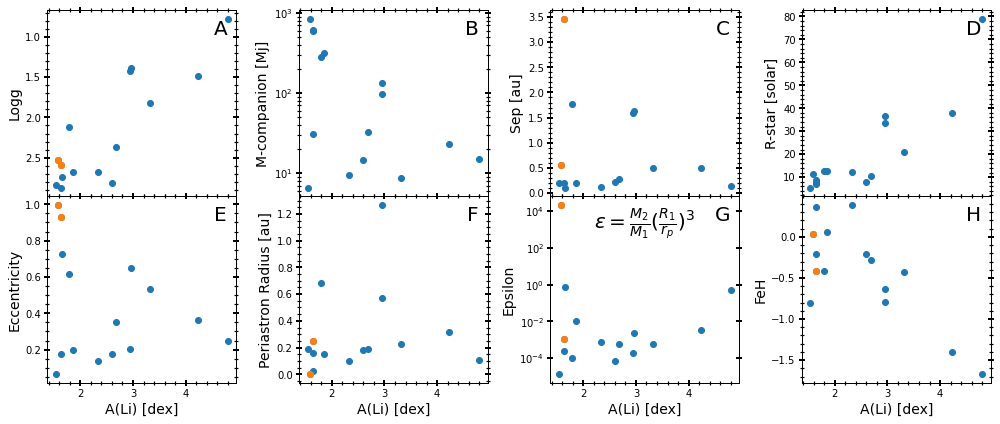

In [18]:

def peri_r(df):
    
    '''
    M1 : primary mass (ie. RG)
    M2 : companion mass
    R1 : primary radius (ie. RG)
    r  : periastron radius
    
    Dimensionless tidal amplitude parameter: 

    epsilon = (M_2/M_1)(R_1/r)^3

    Where R_1 is primary radius, 
    r is orbital separation (or distance at periastron), 
    M_2 is companion mass, M_1 is primary mass

    '''
    dfnew=df.copy()
    
    M1, M2 = df.m_act_bstep.to_numpy(), df.Mj50.to_numpy()
    a, e   = df.a50.to_numpy(), df.e50.to_numpy()
    R1     = df.radius_bstep.to_numpy()

    
    M1   = (M1*u.Msun).to(u.kg)
    M2   = (M2*u.Mjup).to(u.kg)
    a_au = (a*u.au)
    R1   = (R1*u.Rsun).to(u.au)
    r_p  = a_au*(1.-e)

    epsilon = (M2/M1)*(R1/r_p)**3.
    
    dfnew['epsilon'] = epsilon
    dfnew['rperi'] = r_p.value
    fig, ((ax1, ax2, ax3,ax4), (ax5,ax6,ax7, ax8)) = plt.subplots(2,4,figsize=(14,6))
    
    mask = (df.Mj50 <= 600) & (df.Mj50 >=83)
    mask = (df.Mj50 <= 80) & (df.Mj50 >=13)
    mask = (df.Mj50 <= 13)
    mask = (df.Mj50 >= 600)

    d2 = df[mask]
    print(min(d2.e50),max(d2.e50))
    print(np.sort(d2.vbroad))
    print(d2.logg.values)
    print(d2.a50.values)
    print(d2.P50.values)
    ax1.scatter(df.Li_val, df.logg)
    ax1.scatter(d2.Li_val, d2.logg)
    
    ax2.scatter(df.Li_val, df.Mj50)
    
    ax3.scatter(df.Li_val, df.a50)
    ax3.scatter(d2.Li_val, d2.a50)
    
    ax4.scatter(df.Li_val, df.radius_bstep)
    
    ax5.scatter(df.Li_val, df.e50)
    ax5.scatter(d2.Li_val, d2.e50)
    
    ax6.scatter(df.Li_val, df.a50*(1-df.e50))
    ax6.scatter(d2.Li_val, d2.a50*(1-d2.e50))
    
    ax7.scatter(df.Li_val, epsilon)#, c=df.logg)    
    ax7.scatter(d2.Li_val, epsilon[mask])
    #ax7.axvline(2.7)
    ax8.scatter(df.Li_val, df.fe_h)
    ax8.scatter(d2.Li_val, d2.fe_h)
    print(df.logg[mask].tolist())
    print(df.vbroad[mask].tolist())
    
    ax1.set_ylabel('Logg')
    ax2.set_ylabel('M-companion [Mj]')
    ax3.set_ylabel('Sep [au]')
    ax4.set_ylabel('R-star [solar]')
    ax5.set_ylabel('Eccentricity')
    ax6.set_ylabel('Periastron Radius [au]')
    ax7.set_ylabel('Epsilon')
    ax8.set_ylabel('FeH')
    
    ax1.invert_yaxis()
    ax2.set_yscale('log')
    ax7.set_yscale('log')
    
    for ax in [ax5,ax6,ax7,ax8]:
        ax.set_xlabel('A(Li) [dex]')
    
    formula = r'$\epsilon= \frac{M_2}{M_1} (\frac{R_1}{r_p} )^3$'
    
    ax7.text(0.5, 0.95, s=formula, transform=ax7.transAxes,fontsize=20, ha='center',va='top')
    
    for i,ax in zip('ABCDEFGH',[ax1,ax2,ax3,ax4,ax5,ax6,ax7, ax8]):
        ax.text(0.95, 0.95, s=i, transform=ax.transAxes,fontsize=20, ha='right',va='top')
        
    print(d2.fe_h.values)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0)
    #plt.savefig('../plots/diagnostic_%s.png'%DATE,bbox_inches='tight',dpi=200)
    #return dfnew[['RG_id','program','m_act_bstep','radius_bstep','rperi','a50','e50','Mj50','epsilon','Li_val','logg']].sort_values(by=['logg'])

peri_r(table4)


In [19]:
print('Eccentricity range:  %.3f-%.3f' % (min(table4.e50),max(table4.e50)))
print('Period range:  %.2f-%.2f' % (min(table4.P50),max(table4.P50)))
print('Separation range: %.2f-%.2f' % (min(table4.a50),max(table4.a50)))
print('Mstellar range:  %.2f-%.2f' % (min(table4.m_act_bstep),max(table4.m_act_bstep)))
print('FeH range:  %.2f-%.2f' % (min(table4.fe_h),max(table4.fe_h)))

table4[['fe_h','Mj50','m_act_bstep']].sort_values(by=['m_act_bstep'])


Eccentricity range:  0.065-0.997
Period range:  8.85-1525.61
Separation range: 0.10-3.47
Mstellar range:  0.96-2.40
FeH range:  -1.67-0.39


,fe_h,Mj50,m_act_bstep
4,-0.80,6.551242,0.956547
2,-1.67,14.897636,1.027199
8,-0.28,32.775966,1.058158
0,-0.43,8.792316,1.067512
3,-1.40,23.361732,1.106918
0,-0.64,131.982624,1.106920
1,-0.79,98.190374,1.170504
6,-0.21,586.855328,1.243245
7,0.03,847.638951,1.611008
1,-0.42,277.541652,1.667217


1697.46176240809 1.0271986214534212 38668.8654080816 0.386688654080816
[3.22703572 3.23390675 3.43302342 3.73808407 3.74452102 3.74631178
 3.79489462 3.79858855 3.80747185 3.81783666 3.85793877 3.89731365
 3.92318277 3.9270485  3.99492821 4.06601657 4.14737332 4.2207742
 4.29342833 4.35626129 4.37671134 4.43590674 4.47948333 4.84568848
 4.8712719  4.98719992 5.0204076  5.03355829 5.14984633 5.88261369
 6.23575007 6.2898114  6.50969455        nan]
1697.46176240809 1.0271986214534212 38668.8654080816 0.386688654080816
[3.43302342 3.74631178 3.80747185 3.89731365 4.06601657 4.84568848
 4.8712719  4.98719992 5.0204076  5.03355829 5.14984633 5.88261369
 6.23575007 6.2898114  6.50969455]


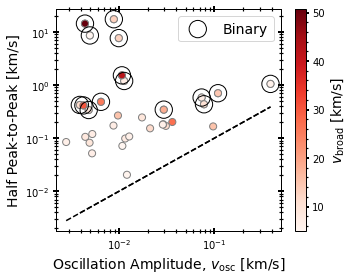

In [20]:
def rv_variable(df, ax,binary=False):
    '''
    check how many out of 34 are RV variable: K>sigma_rv
    see adamow+2018 for details
    '''
    
    def calc_v_osc(L, M):
        '''
        Eq 7 in Kjeldsen & Bedding 1995
        @input: L & M in solar units
        
        @output: vosc in cm/s
        
        
        '''
        return (L/M) * 23.4 #cm/s
        
    def calc_lum(T, R):
        '''
        calculate luminosity
        @input: T in K, R in solar units
        '''
        return R**2.*(T/5777.)**4. 
        
    
    d1 = df.copy()
    all_vosc   = []
    all_K      = []
    all_rv_err = []
    for i,row in df.iterrows():
        dftemp = df[df.sobject_id==row.sobject_id]
        mass    = galah_vac[galah_vac.sobject_id==row.sobject_id].m_act_bstep.values[0]
        log_lum = galah_vac[galah_vac.sobject_id==row.sobject_id].log_lum_bstep.values[0]
        r_bstep = galah_vac[galah_vac.sobject_id==row.sobject_id].radius_bstep.values[0]
        lum     = 10.**log_lum
        _,rv_vals,rv_err = clean_up(dftemp)
        K           = (np.max(rv_vals) - np.min(rv_vals))/2.
        v_osc       = (calc_v_osc(lum, mass)*u.cm/u.s).to(u.km/u.s).value
        mean_rv_err = np.mean(rv_err)
        #print('%.3f \t %.2f \t %.3f' %( v_osc, K, mean_rv_err ))
        if row.sobject_id== 170416004301008:
            print(lum,mass,lum/mass*23.4,(lum/mass*23.4)/1e5)
        # save
        all_vosc.append(v_osc)
        all_K.append(K)
        all_rv_err.append(mean_rv_err)
        
    d1['vosc'] = all_vosc
    d1['K_rv'] = all_K
    d1['mean_rv_err'] = all_rv_err
    
        #print(K,mean_rv_err)
    
    #ax1.scatter(d1.K_rv,d1.mean_rv_err)
#     np.log10(d1.K_rv*1000/d1.vosc)
    im=ax.scatter(d1.vosc,d1.K_rv,c=d1.vbroad,cmap='Reds',ec='grey',s=50)
    if binary:
        ax.scatter(d1.vosc,d1.K_rv,fc='None',ec='k',s=300,label='Binary')
    ax.legend()
    line = np.linspace(min(d1.vosc),max(d1.vosc),1000)
    ax.plot(line, line, c='k', ls='dashed')
    
    print(np.sort(np.log10(d1.K_rv*1000/d1.vosc)))
    return im, d1
    
plt.figure(figsize=(5,4))
ax=plt.subplot(111) 
ax.set_ylabel('Half Peak-to-Peak [km/s]')

ax.set_xlabel(r'Oscillation Amplitude, $v_{\rm osc}$ [km/s]')
ax.set_xscale('log') 
ax.set_yscale('log') 
im,d1=rv_variable(rv_df,ax)
plt.colorbar(im,label=r'$v_{\rm broad}$ [km/s]')
_=rv_variable(table4,ax,binary=True)
plt.tight_layout()
# plt.savefig('../plots/vosc_%s.png'%DATE,bbox_inches='tight',dpi=150)
plt.show()
# d1[['vosc','K_rv','sobject_id','program','RG_id']].sort_values(by=['vosc'])


In [21]:
# table4[(table4.program==113) & (table4.RG_id==21)][['P50','e50','K50']]

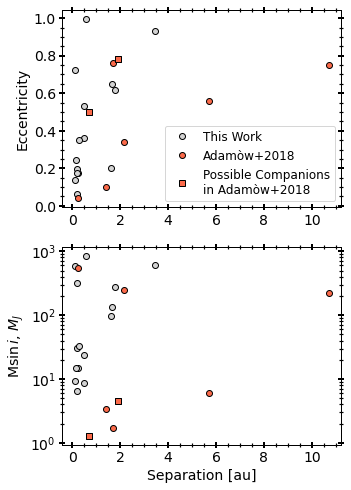

In [22]:
def compare_adamow(df):
    '''
    compare our orbital parameters to Adamow 2014: 
    https://www.aanda.org/articles/aa/pdf/2018/05/aa32161-17.pdf
    '''
    
    d = {
        'TYC 0405-01700-1'  : {'M': 0.53*u.Msun.to(u.Mjup) , 'a': 0.220, 'e': 0.04},
        'TYC 3314-01371-1'  : {'M': 0.235*u.Msun.to(u.Mjup), 'a': 2.17, 'e': 0.3392 },
        'HD 181368'         : {'M': 220, 'a': 10.7 , 'e': 0.75},
        'BD+48 740'         : {'M': 1.7, 'a': 1.7  , 'e': 0.76},
        'HD 238914'         : {'M': 6,   'a': 5.7  , 'e': 0.56 },
        'TYC 3318-01333-1'  : {'M': 3.4, 'a': 1.4  , 'e': 0.1},
        'TYC 3663-01966-1'  : {'M': 1.3, 'a': 0.7  , 'e': 0.5} ,#maybe
        'TYC 3105-00152-1'  : {'M': 4.6, 'a': 1.92 , 'e': 0.78} #maybe   
    }
    
    ec1, fc1 = 'k', 'lightgrey'
    ec2, fc2 = 'k', '#FB6A4A'

    plt.figure(figsize=(5,8))
    PLOT_PARAMS(LS=14, SIZE=14)
    ax1=plt.subplot(211)
    plt.scatter(df.a50, df.e50, ec=ec1,fc=fc1)
    for k, v in d.items():
        if k in ['TYC 3663-01966-1','TYC 3105-00152-1' ]:
            plt.scatter(v['a'], v['e'],ec=ec2,fc=fc2,marker='s')
        else:
            plt.scatter(v['a'], v['e'],ec=ec2,fc=fc2,marker='o')

    ax2=plt.subplot(212)
    plt.scatter(df.a50, df.Mj50, ec=ec1,fc=fc1)
    for k, v in d.items():
        if k in ['TYC 3663-01966-1','TYC 3105-00152-1' ]:
            plt.scatter(v['a'], v['M'],ec=ec2,fc=fc2,marker='s')
        else:
            plt.scatter(v['a'], v['M'],ec=ec2,fc=fc2,marker='o')
    plt.yscale('log')
    ax2.set_xlabel('Separation [au]')
    ax2.set_ylabel('M$\sin i$, $M_J$')
    ax1.set_ylabel('Eccentricity')

    
    lgnd1 = [Line2D([0], [0], marker='o', label='This Work', mfc=fc1, mec=ec1, color='white',  lw=1), 
             Line2D([0], [0], marker='o', label='Adamòw+2018', mfc=fc2, mec=ec2, color='white',  lw=1), 
             Line2D([0], [0], marker='s', label='Possible Companions\nin Adamòw+2018', mfc=fc2, mec=ec2, color='white',  lw=1)]
    
    ax1.legend(handles=lgnd1,loc='lower right',fontsize=12)
    #plt.savefig('../plots/adamow_%s.png'%DATE,bbox_inches='tight',dpi=200)
compare_adamow(table4)
    

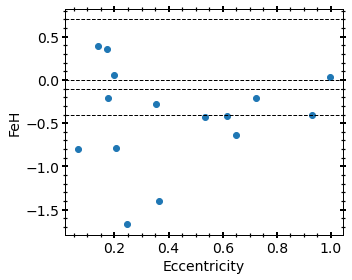

In [23]:
plt.figure(figsize=(5,4))
plt.scatter(table4.e50,table4.fe_h, )
plt.xlabel('Eccentricity')
plt.ylabel('FeH')
plt.axhline(-0.1, c='k',ls='dashed',lw=1)
plt.axhline(-0.4, c='k',ls='dashed',lw=1)
plt.axhline(0, c='k',ls='dashed',lw=1)
plt.axhline(0.7, c='k',ls='dashed',lw=1)
plt.tight_layout()
# plt.savefig('../plots/ecc_vs_feh_%s.png'%DATE,bbox_inches='tight',dpi=200)

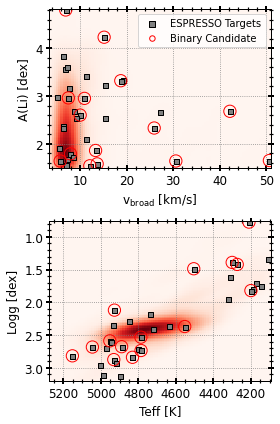

In [24]:
PLOT_PARAMS(LS=12,SIZE=12)
fig, ((ax1),(ax2)) = plt.subplots(2,1,figsize=(4,6))


ax1.scatter(rv_df.vbroad, rv_df.Li_val,ec='k',fc='grey',marker='s',label='ESPRESSO Targets',s=25)
mask_112 = (rv_df.RG_id.isin(binary_list_112) & (rv_df.program==112))
mask_113 = (rv_df.RG_id.isin(binary_list_113) & (rv_df.program==113))
ax1.scatter(rv_df[mask_112].vbroad, rv_df[mask_112].Li_val,ec='r',s=150,fc='None')
ax1.scatter(rv_df[mask_113].vbroad, rv_df[mask_113].Li_val,ec='r',s=150,fc='None',label='Binary Candidate')

ax1.set_xlabel('$\mathrm{v_{broad}}$ [km/s]')
ax1.set_ylabel('A(Li) [dex]')

ax2.scatter(rv_df.teff, rv_df.logg,ec='k',fc='grey',marker='s',label='ESPRESSO Targets',s=25)
ax2.scatter(rv_df[mask_112].teff, rv_df[mask_112].logg,ec='r',s=150,fc='None')
ax2.scatter(rv_df[mask_113].teff, rv_df[mask_113].logg,ec='r',s=150,fc='None',label='Binary Candidate')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax2.set_xlabel('Teff [K]')
ax2.set_ylabel('Logg [dex]')

ax1.grid(ls='dotted',c='grey')
ax2.grid(ls='dotted',c='grey')

lgnd=ax1.legend(fontsize=10)
lgnd.legend_handles[0]._sizes = [30]
lgnd.legend_handles[1]._sizes = [30]


def make_density_plot(x,y,nbins=100):
    from scipy.stats import gaussian_kde

    # Calculate the point density
    k = gaussian_kde([x,y])
    xi, yi = np.mgrid[
       x.min():x.max():nbins*1j,
       y.min():y.max():nbins*1j
    ]
    zi = k(np.vstack([xi.flatten(),yi.flatten()])).reshape(xi.shape)
    return xi,yi,zi

xi,yi,zi=make_density_plot(df_rich.vbroad, df_rich.fe_h+df_rich.Li_fe+1.05)
ax1.pcolormesh(xi, yi, zi,cmap='Reds',zorder=0)

xi,yi,zi=make_density_plot(df_rich.teff, df_rich.logg,)
ax2.pcolormesh(xi, yi, zi,cmap='Reds',zorder=0)

fig.tight_layout()
# plt.savefig('../plots/hrd_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [25]:
print('\n')
print('# with logg < 2.5:',rv_df[rv_df.logg <= 2.5].sobject_id.count())
print('# with logg < 2.5 in 112:',rv_df[mask_112][rv_df[mask_112].logg <= 2.5].sobject_id.count())
print('# with logg < 2.5 in 113:',rv_df[mask_113][rv_df[mask_113].logg <= 2.5].sobject_id.count())
print('total:',7)

print('\n')
print('# with logg = 2.5-3.0:',rv_df[(rv_df.logg >= 2.5) & (rv_df.logg <= 3.0)].sobject_id.count())
print('# with logg = 2.5-3.0 in 112:',rv_df[mask_112][(rv_df[mask_112].logg >= 2.5) & (rv_df[mask_112].logg <= 3.0)].sobject_id.count())
print('# with logg = 2.5-3.0 in 113:',rv_df[mask_113][(rv_df[mask_113].logg >= 2.5) & (rv_df[mask_113].logg <= 3.0)].sobject_id.count())
print('total:',8)

print('\n')
print('# with logg > 3.0:',rv_df[rv_df.logg >= 3.0].sobject_id.count())



# with logg < 2.5: 18
# with logg < 2.5 in 112: 2
# with logg < 2.5 in 113: 5
total: 7


# with logg = 2.5-3.0: 14
# with logg = 2.5-3.0 in 112: 2
# with logg = 2.5-3.0 in 113: 6
total: 8


# with logg > 3.0: 2


In [26]:
table3 = table4.copy() #table4[~((table4.RG_id==23) & (table4.program==112))]


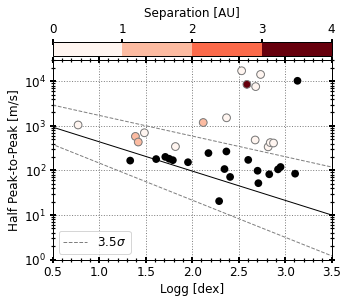

In [27]:
def half_amp_plot(df):
    
    new_d = {'RG_id':[],'program':[], 'logg':[],'half_rv':[]}
    for i, row in df.iterrows():
        program, RG_id = row.program,row.RG_id
        dtemp = df[(df.program==program) & (df.RG_id==RG_id)]
        _,rv_vals,_ = clean_up(dtemp)
        half_rv  = (max(rv_vals)-min(rv_vals))/2.
        new_d['logg'].append(dtemp.logg.values[0])
        new_d['half_rv'].append(half_rv)
        new_d['program'].append(program)
        new_d['RG_id'].append(RG_id)
    new_d = pd.DataFrame(new_d)
    
    new_d1 = pd.merge(table3[table3.program==112], new_d[new_d.program==112],on='RG_id')
    new_d2 = pd.merge(table3[table3.program==113], new_d[new_d.program==113],on='RG_id')
    new_d1 = pd.concat([new_d1, new_d2])
    
    plt.figure(figsize=(5,4))
    ax=plt.subplot(111)
    
    bounds = [0,1,2,3,4]
    cmap_color = 'Reds'
    cmap = plt.get_cmap(cmap_color, len(bounds))
    norm = colors.BoundaryNorm(bounds, cmap.N)
    clabel = 'Separation [AU]'

    mask_112 = (new_d.RG_id.isin(binary_list_112) & (new_d.program==112))
    mask_113 = (new_d.RG_id.isin(binary_list_113) & (new_d.program==113))

    plt.scatter(new_d.logg, new_d.half_rv*1000,ec='None',fc='k',s=60)
    im=plt.scatter(new_d1.logg_x, new_d1.half_rv*1000,c=new_d1.a50,cmap=cmap, norm=norm,ec='grey',s=60)
    #plt.scatter(new_d[mask_112].logg, new_d[mask_112].half_rv*1000,ec='r',s=150,fc='None')
    #plt.scatter(new_d[mask_113].logg, new_d[mask_113].half_rv*1000,ec='r',s=150,fc='None',label='Binary Candidate')
    
    plt.yscale('log')
    plt.xlabel('Logg [dex]')
    plt.ylabel('Half Peak-to-Peak [m/s]')
    plt.xlim(0.5,3.5)
    plt.ylim(1,3e4)
    
    def semi_log(y1, x2, y2, x, x1=0):
        b = np.log10(y1)
        m = (1./x2)*np.log10(y2/y1)
        y = 10**(m*x+b)
        return y
    x = np.linspace(0,4,100)    

    y1=semi_log(2000, 3.5, 10, x)
    y2=semi_log(1000, 2.4, 10, x)
    y3=semi_log(5000, 4.0, 70, x)
    
    plt.plot(x,y1, c='k',ls='solid',lw=1)
    plt.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
    plt.plot(x,y3, c='grey',ls='dashed',lw=1)
    plt.legend(loc='lower left')
    
    plt.grid(ls='dotted',lw=1,c='grey')
    
    

    ax2_divider = make_axes_locatable(ax)
    cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
    cb2 = fig.colorbar(im, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
    cax2.xaxis.set_ticks_position("top") # change tick position to top
    cb2.ax.set_title(clabel)

#     plt.savefig('../plots/peak_to_peak_%s.png'%DATE,bbox_inches='tight',dpi=200)

half_amp_plot(rv_df)


In [28]:
def wd_eq1(mf):
    'from cummings 2018'
    return (mf-0.489)/0.080
def wd_eq2(mf):
    'from cummings 2018'
    return (mf-0.184)/0.187
def wd_eq3(mf):
    'from cummings 2018'
    return (mf-0.471)/0.107

print(wd_eq1(0.6),wd_eq2(0.6),wd_eq3(0.6))
print(wd_eq1(0.8),wd_eq2(0.8),wd_eq3(0.8))

1.3874999999999997 2.2245989304812834 1.205607476635514
3.8875000000000006 3.2941176470588243 3.074766355140188


In [29]:
def wd_eq1(mf):
    'from cummings 2024 ? cunningham?????'
    return (mf-0.469)/0.086
def wd_eq2(mf):
    'from cummings 2024'
    return (mf-0.40)/0.1
def wd_eq3(mf):
    'from cummings 2024'
    return (mf-0.57)/0.06
def wd_eq4(mf):
    'from cummings 2024'
    return (mf-0.04)/0.17
def wd_eq4b(mf):
    'from cummings 2024'
    return (mf+0.04)/0.15

print(wd_eq1(0.6),wd_eq2(0.6),wd_eq3(0.6),wd_eq4(0.6),wd_eq4b(0.6))
print(wd_eq1(0.8),wd_eq2(0.8),wd_eq3(0.8),wd_eq4(0.8),wd_eq4b(0.8))

1.5232558139534886 1.9999999999999996 0.5000000000000004 3.294117647058823 4.266666666666667
3.8488372093023266 4.0 3.833333333333335 4.470588235294118 5.6000000000000005


In [30]:
print('masses 3.6-7.2:')

def wd_eq(mf):
    '''from Cummings2018, eq 6'''
    return (mf-0.471)/0.107
print(wd_eq(0.6), wd_eq(0.8) )

print('inflate final mass by 20% (Shahaf 2025):')
print(wd_eq(0.6*1.2), wd_eq(0.8*1.2) )

print('inflate final mass by 75% after correcting for mass loss (Cummings2018) ')
print(wd_eq(0.6*1.75), wd_eq(0.8*1.75) )

print('# inflate final mass by 85% after correcting for mass loss (Cummings2018) ')
print(wd_eq(0.6*1.85), wd_eq(0.8*1.85) )



    

masses 3.6-7.2:
1.205607476635514 3.074766355140188
inflate final mass by 20% (Shahaf 2025):
2.3271028037383177 4.570093457943925
inflate final mass by 75% after correcting for mass loss (Cummings2018) 
5.4112149532710285 8.682242990654208
# inflate final mass by 85% after correcting for mass loss (Cummings2018) 
5.971962616822431 9.429906542056077


Text(0, 0.5, 'Period [days]')

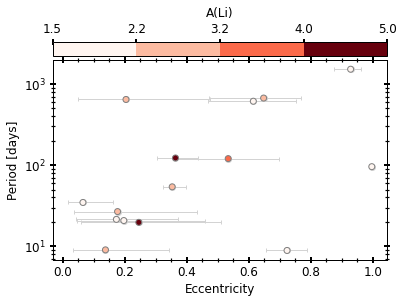

In [31]:
bounds = [1.5, 2.2, 3.2, 4, 5.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.e50, table3.P50,color='lightgrey', xerr=[table3.e50-table3.e16,table3.e84-table3.e50],
            yerr=[table3.P50-table3.P16,table3.P84-table3.P50],capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1)

im1=plt.scatter(table3.e50, table3.P50, c=table3.Li_val,cmap=cmap, norm=norm,ec='grey')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xlabel('Eccentricity')
ax1.set_ylabel('Period [days]')
# plt.savefig('../plots/e_P_li_%s.png'%DATE,bbox_inches='tight',dpi=200)


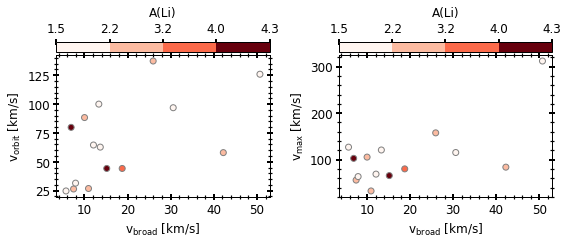

In [32]:

# a_all.v_max.to_numpy()[0].to(u.km/u.hour)
bounds = [1.5, 2.2, 3.2, 4, 4.3]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

plt.figure(figsize=(8,3.5))
ax1=plt.subplot(121)
im1=plt.scatter(table3.vbroad, table3.v_orb, c=table3.Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('v$_\mathrm{broad}$ [km/s]')

plt.ylabel('v$_\mathrm{orbit}$ [km/s]')

line=np.linspace(min(table3.vbroad),max(table3.vbroad),1000)
# plt.plot(line,line,c='k')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax2=plt.subplot(122)
im2=plt.scatter(table3[table3.v_max<1000].vbroad,table3[table3.v_max<1000].v_max, c=table3[table3.v_max<1000].Li_val, cmap=cmap, norm=norm,ec='grey')
plt.xlabel('v$_\mathrm{broad}$ [km/s]')
plt.ylabel('v$_\mathrm{max}$ [km/s]')

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax2.xaxis.set_ticks_position("top") # change tick position to top
cb2.ax.set_title(clabel)

# ax2.set_xscale('log')
# ax2.set_yscale('log')


plt.tight_layout()
# plt.savefig('../plots/vbroad_vmax_vorb_%s.png'%DATE,bbox_inches='tight',dpi=200)
plt.show()

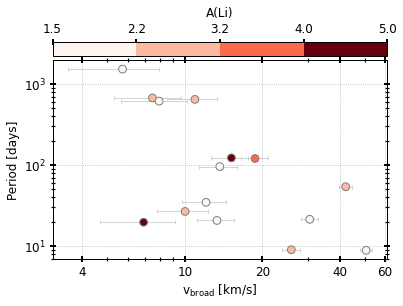

In [33]:
bounds = [1.5, 2.2, 3.2, 4, 5.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'A(Li)'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1,color='lightgrey')

im1=plt.scatter(table3.vbroad, table3.P50, c=table3.Li_val,cmap=cmap, norm=norm,ec='grey',s=60)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xscale('log')
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)


ax1.set_xlabel('v$_{\mathrm{broad}}$ [km/s]')
ax1.set_ylabel('Period [days]')
ax1.grid(ls='dotted')
# ax1.set_ylim(25.44715063069063, 1858.443368942767)
# ax1.set_xlim(3.063198120106046, 61.2462833430784)

# plt.savefig('../plots/a1_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [34]:
table4[(table4.program==113) & (table4.RG_id==16)][['P50','e50']]

,P50,e50
6,8.852944,0.723809


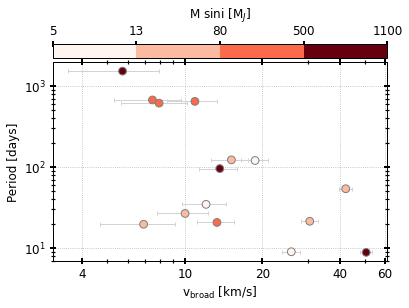

In [35]:
bounds = [5,13,80,500,1100]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'M sini [M$_J$]'

fig=plt.figure(figsize=(6,4))
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             capsize=2, fmt='o',mec=None,mfc=None,zorder=-100,lw=1,color='lightgrey')

im1=plt.scatter(table3.vbroad, table3.P50, c=table3.Mj50,cmap=cmap, norm=norm,ec='grey',s=60)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

ax1.set_yscale('log')
ax1.set_xscale('log')
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)


ax1.set_xlabel('v$_{\mathrm{broad}}$ [km/s]')
ax1.set_ylabel('Period [days]')
ax1.grid(ls='dotted')
# ax1.set_ylim(25.44715063069063, 1858.443368942767)
# ax1.set_xlim(3.063198120106046, 61.2462833430784)

# plt.savefig('../plots/a2_%s.png'%DATE,bbox_inches='tight',dpi=200)


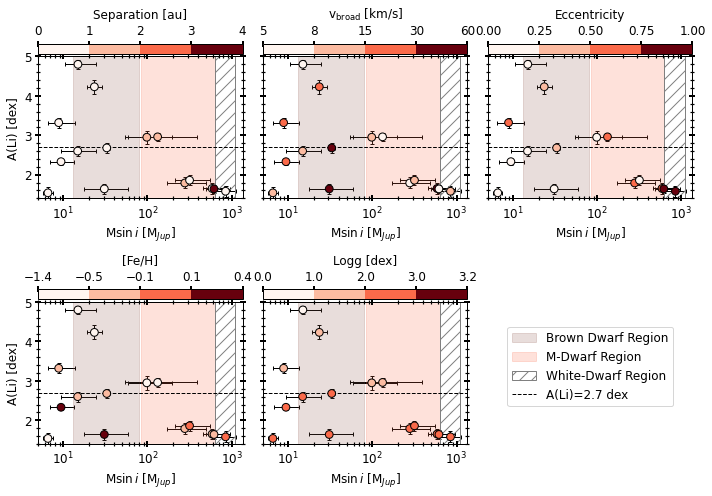

In [42]:
mearth = (u.Mjup).to(u.Mearth)
msolar = (u.Msun).to(u.Mjup)

PLOT_PARAMS(LS=12, SIZE=12)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10,7), sharex=True, sharey=True)

bounds = [0,1.0,2.0,3.0,4.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'Separation [au]'

im1=ax1.scatter(table3.Mj50, table3.Li_val,c=table3.a50,cmap=cmap,norm=norm,ec='k',s=60)
ax1.set_xscale('log')
ax1.set_ylabel('A(Li) [dex]')

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax1.xaxis.set_ticks_position("top") # change tick position to top
cb1.ax.set_title(clabel)

# ax1=plt.subplot(132,sharex=ax1,sharey=ax1)
bounds = [5,8,15,30,60]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'v$_{\mathrm{broad}}$ [km/s]'

im2=ax2.scatter(table3.Mj50, table3.Li_val,c=table3.vbroad,cmap=cmap,norm=norm,ec='k',s=60)
ax2.set_xscale('log')

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax2.xaxis.set_ticks_position("top") # change tick position to top
cb2.ax.set_title(clabel)

bounds = [0,0.25,0.5,0.75,1.0]
# bounds = [0,0.2,0.4,0.6,0.8,1.0]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'Eccentricity'

im3=ax3.scatter(table3.Mj50, table3.Li_val,c=table3.e50,cmap=cmap,norm=norm,ec='k',s=60)
ax3.set_xscale('log')

ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax3.xaxis.set_ticks_position("top") # change tick position to top
cb3.ax.set_title(clabel)

bounds = [-1.40,-0.5, -0.1,0.1, 0.4]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = '[Fe/H]'

im4=ax4.scatter(table3.Mj50, table3.Li_val,c=table3.fe_h,cmap=cmap,norm=norm,ec='k',s=60)
ax4.set_xscale('log')

ax4_divider = make_axes_locatable(ax4)
cax4 = ax4_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb4 = fig.colorbar(im4, cax=cax4, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax4.xaxis.set_ticks_position("top") # change tick position to top
cb4.ax.set_title(clabel)
ax4.set_ylabel('A(Li) [dex]')

bounds = [0., 1.0, 2.0, 3.0, 3.2]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'Logg [dex]'

im5=ax5.scatter(table3.Mj50, table3.Li_val,c=table3.logg,cmap=cmap,norm=norm,ec='k',s=60)
ax5.set_xscale('log')


ax5_divider = make_axes_locatable(ax5)
cax5 = ax5_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb5 = fig.colorbar(im5, cax=cax5, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax5.xaxis.set_ticks_position("top") # change tick position to top
cb5.ax.set_title(clabel)
max(table3.logg)

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_xlabel(r'M$ \sin i$ [M$_{Jup}$]')
    ax.errorbar(table3.Mj50, table3.Li_val, 
                xerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],
                yerr=table3.e_Li_val, fmt='o', 
                color='k',lw=1, capsize=2, mec='None',mfc='None',zorder=-100)
    
    
    # M-dwarf limit
    ax.axvspan(0.08*msolar, 0.6*msolar, color=cmap(0.5), alpha=0.2, label='M-Dwarf',zorder=-100)
    #ax.text(0.65, 0.95, 'M-Dwarf\nRegion',fontsize=10, ha='center',va='top',transform=ax.transAxes)

    
    # 0.6 Msun (white dwarf peak)
    #ax.axvline(0.6*msolar,c='k',ls='dotted',zorder=-1)
    #ax.text(0.6*msolar, 4.8, '$\mathrm{0.6 \; M_\odot}$',ha='center',fontsize=10, c='k', va='top')
    ax.axvspan(0.6*msolar, 1100, fc='none',hatch='//',ec='grey',zorder=-100)

    
    # Brown Dwarf :
    ax.axvspan(13, 80, color='tab:brown', alpha=0.2, label='Brown Dwarf',zorder=-100)
    #ax.text(0.33, 0.05, 'Brown Dwarf\nRegion',fontsize=10, ha='center',va='bottom',transform=ax.transAxes)
    
    # Dashed line for Li=2.7
    ax.axhline(2.7,c='k',ls='dashed',zorder=-1,lw=1)
    ax.tick_params(axis='x', labelbottom=True)

ax1.set_ylim(1.4, 5.0)
ax1.set_xlim(5, 1350)

lgnd = [Patch(color='tab:brown', alpha=0.2, label='Brown Dwarf Region'), 
        Patch(color=cmap(0.5), alpha=0.2, label='M-Dwarf Region'), 
        Patch(fc='none',ec='grey', hatch='//', label='White-Dwarf Region'), 
        Line2D([0], [0], color='k', lw=1, label='A(Li)=2.7 dex',ls='dashed'),
       ]
ax6.legend(handles=lgnd, loc='center')
ax6.set_axis_off()

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# plt.savefig('../plots/msini_vs_ali_mix_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [37]:
ss

NameError: name 'ss' is not defined

In [ ]:
table4.sort_values(by='Mj50')[['obj_name','program','RG_id','teff','Li_val','m_act_bstep','fe_h','logg','P50','e50','Mj50','vbroad']]#[table4.Mj50<100]

In [ ]:
table4[table4.Mj50<100].Li_val
table4[(table4.program==113) & (table4.RG_id==7)][['obj_name','sobject_id','fe_h','logg']]

In [ ]:
min(table4[table4.Li_val<=2.7].logg),max(table4[table4.Li_val<=2.7].logg),

In [ ]:
PLOT_PARAMS()
bounds = [4,10,20,40,60]
cmap_color = 'Reds'
cmap = plt.get_cmap(cmap_color, len(bounds))
norm = colors.BoundaryNorm(bounds, cmap.N)
clabel = 'v$_{\mathrm{broad}}$ [km/s]'
print

real_size  = table3.Mj50.to_numpy()
mask0 = (real_size < 13)
mask1 = ((real_size >= 13) & (real_size < 80))
mask2 = ((real_size >= 0.08*msolar) & (real_size < 0.6*msolar))
mask3 = (real_size >= 0.6*msolar)

dummy_size = np.zeros(len(real_size))
dummy_size[mask0] = 30
dummy_size[mask1] = 80
dummy_size[mask2] = 300
dummy_size[mask3] = 700

plt.figure(figsize=(6,4))

ax=plt.subplot(111)
im = plt.scatter(table3.Li_val, table3.P50, s= dummy_size,ec='k', c=table3.vbroad,cmap=cmap,norm=norm)
plt.scatter(table3[mask0].Li_val, table3[mask0].P50, s= dummy_size[mask0],ec='k', c=table3[mask0].vbroad,cmap=cmap,norm=norm)
lgnd = [Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(30),ls='',label='$\mathrm{M \sin(i) < 13 \; M_J}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(80),ls='',label='$\mathrm{M \sin(i) = 13-80 \; M_J}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(300),ls='',label='$\mathrm{M \sin(i) = 0.08 - 0.6 \; M_\odot}$'), 
        Line2D([0], [0], marker='o', mec='k',mfc=cmap(0.25),ms=np.sqrt(700),ls='',label='$\mathrm{M \sin(i) > 0.6 \; M_\odot}$'), 
       ]
ax.legend(handles=lgnd,fontsize=12)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
cb = fig.colorbar(im, cax=cax, orientation="horizontal", boundaries=bounds, ticks=bounds)
cax.xaxis.set_ticks_position("top") # change tick position to top
cb.ax.set_title(clabel)

ax.set_yscale('log')
ax.set_xlabel('A(Li) [dex]')
ax.set_ylabel('Period [days]')
plt.tight_layout()

# plt.savefig('../plots/p_vs_li_size_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [ ]:
plt.figure()
plt.scatter(table3.P50,table3.Mj50/(table3.m_act_bstep*u.Msun.to(u.Mjup)),)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Period [days]')
plt.ylabel('Mass ratio')
plt.xlim(1,1e5)
plt.ylim(0.004,1)
plt.axhline()

In [ ]:
PLOT_PARAMS()
plt.figure(figsize=(6,4))
bins=np.arange(0.5,4,0.5)
d1 = rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))]#.Li_val.values
d2 = rv_df[(rv_df.program==113) & (rv_df.RG_id.isin(binary_list_113))]#.Li_val.values
both_galah = pd.concat([d1, d2])

x1=plt.hist(rv_df.logg.values, bins=bins, label='Observed',color='lightgrey', ec='k')
# plt.hist(rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))].Li_val.values, bins=bins, label='Observed',color='lightgrey', ec='k')
x2=plt.hist(both_galah.logg.values, bins=bins, label='Binary',color='darkred', ec='k')
plt.xlabel('A(Li) [dex]')
plt.ylabel('Counts')
plt.legend()
# plt.savefig('../plots/logg_fraction_%s.png'%DATE,bbox_inches='tight',dpi=150)
print(x1[0])
print(x2[0])
print(x2[0]/x1[0])

In [ ]:
PLOT_PARAMS()
plt.figure(figsize=(6,4))
bins=np.arange(1.5, 5.5, 0.5)
d1 = rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))]#.Li_val.values
d2 = rv_df[(rv_df.program==113) & (rv_df.RG_id.isin(binary_list_113))]#.Li_val.values
both_galah = pd.concat([d1, d2])

plt.hist(rv_df.Li_val.values, bins=bins, label='Observed',color='lightgrey', ec='k')
# plt.hist(rv_df[(rv_df.program==112) & (rv_df.RG_id.isin(binary_list_112))].Li_val.values, bins=bins, label='Observed',color='lightgrey', ec='k')
plt.hist(both_galah.Li_val.values, bins=bins, label='Binary',color='darkred', ec='k')
plt.xlabel('A(Li) [dex]')
plt.ylabel('Counts')
plt.legend()
# plt.savefig('../plots/binary_fraction_%s.png'%DATE,bbox_inches='tight',dpi=150)


In [ ]:
ax1=plt.subplot(111)


In [ ]:
plt.hist(table3.vbroad,ec='k')

In [ ]:
cols=['RG_id','program','P50','e50','Li_val','vbroad','Mj50','a50','logg']
table3[cols].sort_values(by='vbroad')

In [ ]:
plt.figure(figsize=(6,4))
color='brown'
ax1=plt.subplot(111)
plt.errorbar(table3.vbroad, table3.P50, xerr=table3.e_vbroad,
             yerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             fmt='o',c='grey',mfc=color,mec=color,capsize=2)#,c=table3.Ba_fe)
# plt.colorbar()
plt.xlabel('v$_{\mathrm{broad}}$ [km/s]')
plt.ylabel('Period [days]')
plt.yscale('log')
plt.xscale('log')

def func(x, m, b):
    
    return m*x + b

from scipy.optimize import curve_fit

xdata,ydata = table3.vbroad.to_numpy(), table3.P50.to_numpy()
mask = np.argsort(xdata)
xdata,ydata = xdata[mask],ydata[mask]
xlog, ylog = np.log10(xdata),np.log10(ydata)
popt, pcov = curve_fit(func, xlog, ylog)

xvals = np.log10(np.linspace(4, 60, 100))
xticks = [4, 10, 20,40, 60]
xlabels = ['%i' %x for x in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)
plt.grid(ls='dotted')

plt.plot(10.**xvals, 10.**func(xvals, *popt), 'k-',
         label='log(P) = $%.1f*\log(v_{br}$) + %.1f' % tuple(popt))
# print(plt.ylim())
# print(plt.xlim())
plt.legend(loc='upper right')
plt.ylim(25.44715063069063, 1858.443368942767)
plt.xlim(3.063198120106046, 61.2462833430784)
# plt.savefig('../plots/b.png',bbox_inches='tight',dpi=200)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax2.sharey(ax1)

ax1.errorbar(table3.Li_val, (table3.Mj50*u.Mjup), 
             xerr=table3.e_Li_val,
             yerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],
             fmt='o',capsize=2, c='k')
ax1.set_yscale('log')
ax1.set_ylabel('M sini [$M_J$]')
ax1.set_xlabel('A(Li) [dex]')
ax1.set_ylim(4.4,1800)

ax2.errorbar(table3.P50, (table3.Mj50*u.Mjup), 
             xerr=[table3.P50-table3.P16,table3.P84-table3.P50],
             yerr=[table3.Mj50-table3.Mj16,table3.Mj84-table3.Mj50],
             fmt='o',capsize=2, c='k')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Period [days]')

mearth = (u.Mjup).to(u.Mearth)
msolar = (u.Msun).to(u.Mjup)



for ax in [ax1,ax2]:

    ax.axhline(msolar,c=cmap(0.5),ls='dotted',lw=1,label='1 $M_\odot$')

    ax.axhline(0.4*msolar,c=cmap(0.75),ls='dotted',lw=1, label='0.4 $M_\odot$')
    
    ax.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')
    
    ax.axhspan(30, 55, ec='k', hatch='//',zorder=100,fc='None')

xi = 4.5
ax1.text(xi, 20, s='Brown Dwarf Range', ha='right',va='top', c='k',fontsize=12)
ax1.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c=cmap(0.75),fontsize=14)
ax1.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c=cmap(0.5),fontsize=14)
xi = 1700
ax2.text(xi, 20, s='Brown Dwarf Range', ha='right',va='top', c='k',fontsize=12)
ax2.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c=cmap(0.75),fontsize=14)
ax2.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c=cmap(0.5),fontsize=14)

ax1.annotate("Brown Dwarf Dessert",  # Text to display
    xy=(3.5, 50),  # Point to annotate
    xytext=(3.5 ,100),  # Position of the text
    ha='center',fontsize=12,
    arrowprops=dict(arrowstyle="->", color="black"),  # Arrow properties
)

# ax2.axhline(msolar,c='r',ls='dotted',lw=1,label='1 $M_\odot$')
# ax2.text(xi, msolar, s='1 $M_\odot$', ha='right',va='bottom', c='r',fontsize=14)

# ax2.axhline(0.4*msolar,c='C0',ls='dotted',lw=1, label='0.4 $M_\odot$')
# ax2.text(xi, 0.4*msolar, s='0.4 $M_\odot$', ha='right',va='bottom', c='C0',fontsize=14)

# #plt.axhline(mearth,c='C1',ls='dotted',lw=1,label='1 $M_\oplus$')
# #plt.text(4.5, mearth, s='1 $M_\oplus$', ha='right',va='top', c='C1',fontsize=14)

# ax2.axhspan(13, 80, color='tab:brown', alpha=0.3, label='Brown Dwarf')

# ax2.axhspan(30, 55, ec='k', hatch='//',zorder=100,fc='None')

ax2.annotate("Brown Dwarf Dessert",  # Text to display
    xy=(500, 50),  # Point to annotate
    xytext=(500 ,100),  # Position of the text
    ha='center',fontsize=12,
    arrowprops=dict(arrowstyle="->", color="black"),  # Arrow properties
)

plt.tight_layout()

plt.subplots_adjust(wspace=0)

ax2.set_yticklabels([])

# plt.savefig('../plots/msini_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [ ]:
def plot_joker_samples(df, obj, program, ax, version=1):
#     if (obj==16 or obj==11) and program=='p113':
#         version = 2
#     else:

    dftemp  = df[(df.RG_id==obj) & (rv_df.program==program)]
    time, rv, rv_err = clean_up(dftemp)
    time, rv, rv_err = np.array(time), np.array(rv), np.array(rv_err)
    
    if program == 113 and obj in [5, 16, 11, 21]: #exclude galah data point
        mask = (time >= 2460000.)
        time, rv, rv_err = time[mask], rv[mask], rv_err[mask]
    elif program == 112 and obj in [7, 23]:  #exclude galah data point
        mask = (time >= 2460000.)
        time, rv, rv_err = time[mask], rv[mask], rv_err[mask]

    rv_err                = np.array(rv_err)
    rv_err[(rv_err<0.10)] = 0.10

    fname   = '../mcmc/%s_%s_joker_%s.hdf5'%(program,obj,version)
    joker_samples = tj.JokerSamples.read(fname)
    
    data = Table()
    data['bjd']     = time
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s
    
    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))
    PLOT_PARAMS()

    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)
    if program==112:
        ax.text(0.5, 0.9, 'P112 - RG %s'%obj, transform=ax.transAxes,fontsize=14, ha='center')
    else:
        ax.text(0.5, 0.9, 'P113 - RG %s'%obj, transform=ax.transAxes,fontsize=14, ha='center',)

In [ ]:
ax=plt.subplot(111)
plot_joker_samples(rv_df, 7, program=112, ax=ax)

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(15, 17),dpi=200)

for i, ax in enumerate(fig.axes):

    if i < len(binary_list_112):
        obj = binary_list_112[i]
        plot_joker_samples(rv_df, obj, program=112, ax=ax)
    elif i >= len(binary_list_112):
        obj = binary_list_113[i-len(binary_list_112)]
        plot_joker_samples(rv_df, obj, program=113, ax=ax)
    if i<12:
        ax.xaxis.label.set_visible(False)

        #ax.tick_params(axis='both', bottom=False, labelbottom=False)
    if i not in np.arange(0,16,3):
        ax.yaxis.label.set_visible(False)
        #ax.tick_params(axis='both', left=False, labelleft=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.savefig('../plots/all_joker_samples_%s.png'%DATE,bbox_inches='tight',dpi=200)


In [ ]:
ss

In [ ]:
# fig=plt.figure(figsize=(7,4),dpi=200)
# ax=plt.subplot(111)
# plot_joker_samples(rv_df, 13, program=112, ax=ax)

In [ ]:
# fig=plt.figure(figsize=(7,4),dpi=200)
# ax=plt.subplot(111)
# plot_joker_samples(rv_df, 18, program=113, ax=ax)

In [ ]:
# fig=plt.figure(figsize=(7,4),dpi=200)
# ax=plt.subplot(111)
# # plot_joker_samples(rv_df, 16, program=113, ax=ax)

In [ ]:
d1 = Table.read('../files/espresso_final_result.fits').to_pandas()
d2 = pd.merge(d1, table3, left_on='sobject_id',right_on='sobject_id')#.keys()
plt.figure()

plt.scatter(d2.logg_c, d2.logg_x)
plt.xlabel('Logg from Anne [dex]')
plt.ylabel('Logg from Galah [dex]')
line=np.linspace(min(d2.logg_c), max(d2.logg_c),1000)
plt.plot(line,line)
len(d2)

In [ ]:
table3[['RG_id','program','P50','e50','Li_val','vbroad','Mj50','a50','logg','m_act_bstep','K50','fe_h']].sort_values(by='Mj50')


In [44]:
def get_k_amp(P, msini, Mstar, e):
    '''
    P     : in days
    Mstar : solar mass
    msini : jupiter mass
    e     : dimensionless
    
    '''
    P = (P*u.day).to(u.second)
    msini = (msini*u.Mjup).to(u.kg)
    Mstar = (Mstar*u.M_sun).to(u.kg)
    e = e*u.dimensionless_unscaled
   
    # define constants
    pi = np.pi
    G  = const.G
    
    K = msini/((P/(2*pi*G))**(1./3)*(Mstar+msini)**(2./3)*(1-e)**0.5)
    
    K = K.to(u.km/u.s)
    
    return K.value


83.80524117283818 628.5393087962863
19


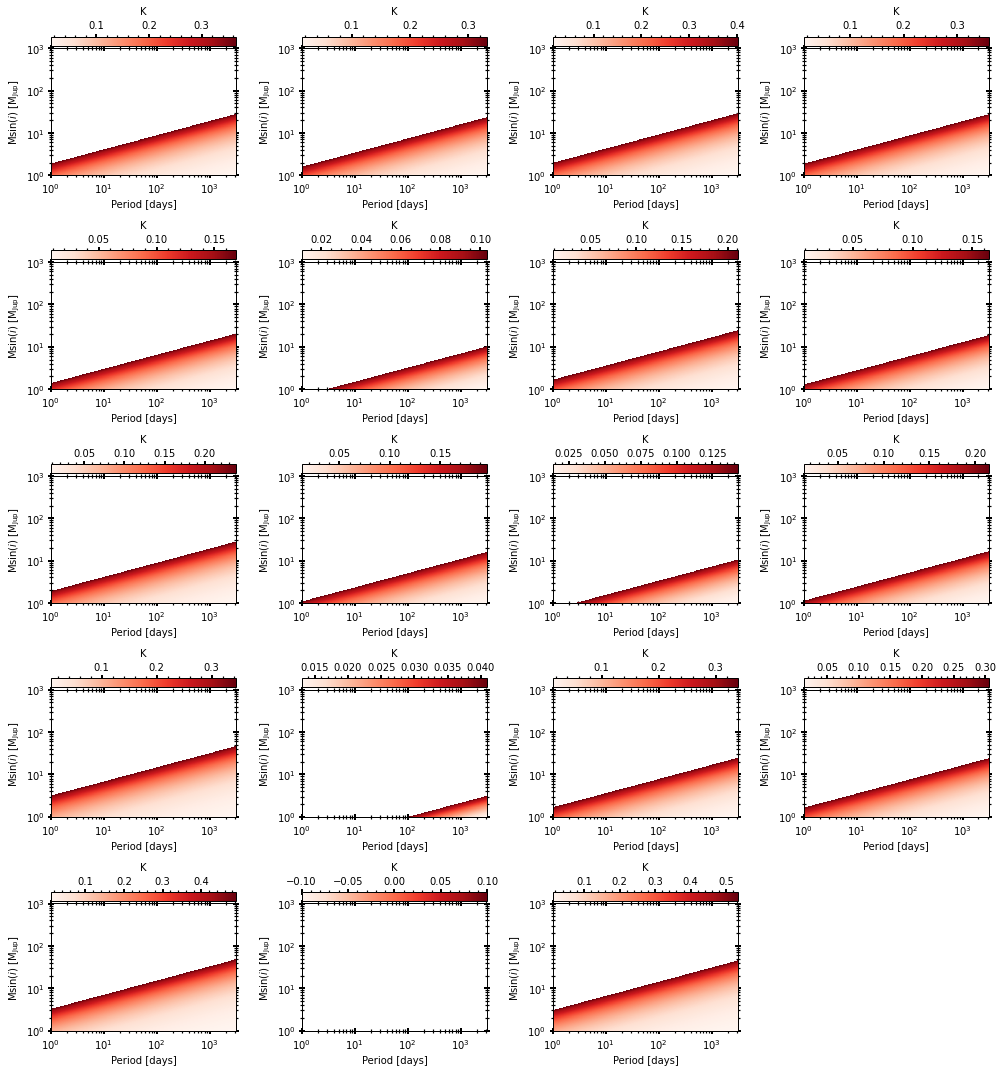

In [66]:


mdwarf_low, mdwarf_up = 0.08*msolar, 0.6*msolar
print(mdwarf_low, mdwarf_up)
Pvals      = np.logspace(0, 3.5, 1000)
msini_vals = np.logspace(0, 3, 500)#np.log10(mdwarf_low), np.log10(mdwarf_up), 1000)

Ms,Ps = np.meshgrid(msini_vals,Pvals)
from matplotlib.colors import LogNorm


d1tempa = rv_df[(rv_df.program==113) & (~rv_df.RG_id.isin(binary_list_113))]
d1tempb = rv_df[(rv_df.program==112) & (~rv_df.RG_id.isin(binary_list_112))]
d1temp  = pd.concat([d1tempa, d1tempb])
d1temp  = pd.merge(d1temp, galah_vac[['sobject_id','m_act_bstep','e_m_act_bstep','radius_bstep','e_radius_bstep']], left_on='galah_id',right_on='sobject_id')
print(len(d1temp))
def non_binary_msini(df,ecc):
    non_binary_d = {'sobject_id':[],'Klim':[],'max_msini':[], }
    fig  = plt.figure(figsize=(14,15))
    PLOT_PARAMS(SIZE=10,LS=10)

    for j,star in enumerate(df.galah_id.to_numpy()):
        d2temp      = d1temp[d1temp.galah_id==star]#.m_act_bs
        Mstar       = d2temp.m_act_bstep.values[0]
        _,rv_vals,_ = clean_up(d2temp)
        Klim  = max(rv_vals)-min(rv_vals)
        
        Kvals = get_k_amp(Ps, Ms, Mstar, e=ecc)
        mask  = (Kvals > Klim)
        Kvals[mask] = np.nan
        #print(star,Mstar, Klim,)
        # plt.imshow(Kvals,origin='lower',extent=[Pvals[0], Pvals[-1], msini_vals[0], msini_vals[-1]],aspect='auto')

        ax   = plt.subplot(5,4,j+1)
        mesh = ax.pcolormesh(Ps, Ms, Kvals, cmap='Reds')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Period [days]')
        ax.set_ylabel(r'M$\sin(i)$ [M$_{\rm Jup}$]')

        # Add a colorbar
        #fig.colorbar(mesh, ax=ax,label='K-amplitude')
        try:
            max_index_flat = np.nanargmax(Kvals)
            # Convert the flat index to 2D coordinates
            max_index_2d = np.unravel_index(max_index_flat, Kvals.shape)
            index_of_Ps, index_of_Ms  = max_index_2d
            #plt.scatter(msini_vals[index_of_Ms], Pvals[index_of_Ps],c='lightgreen',s=70)
            max_msini = msini_vals[index_of_Ms]
        except Exception as e:
            max_msini = np.nan

        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("top", size="7%", pad="2%") # add an axes above the main axes.
        cb = fig.colorbar(mesh, cax=cax, orientation="horizontal")
        cax.xaxis.set_ticks_position("top") # change tick position to top
        cb.ax.set_title('K')

        non_binary_d['sobject_id'].append(star)
        non_binary_d['Klim'].append(Klim)
        non_binary_d['max_msini'].append(max_msini)
    plt.tight_layout()
    plt.show()
    non_binary_d = pd.DataFrame(non_binary_d)
    return non_binary_d
non_binary_d = non_binary_msini(d1temp,ecc=0)


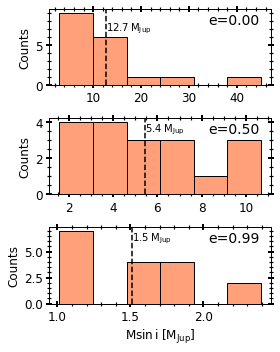

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(4,5))
# ax1.hist(non_binary_d[non_binary_d.e_val==0].max_msini,bins='auto', color='lightsalmon',ec='k')
# ax2.hist(non_binary_d[non_binary_d.e_val==0.50].max_msini,bins='auto',color='lightsalmon',ec='k')
# ax3.hist(non_binary_d[non_binary_d.e_val==0.99].max_msini,bins='auto',color='lightsalmon',ec='k')

for ax, ecc in zip([ax1, ax2, ax3], [0,0.5,0.99]):
    ax.text(0.95, 0.95, s='e=%.2f'%ecc, transform=ax.transAxes,fontsize=14, ha='right',va='top')
    ax.set_ylabel('Counts')

for ax, ecc, y in zip([ax1, ax2, ax3], [0,0.50,0.99], [8, 4, 7]):
    ax.hist(non_binary_d[non_binary_d.e_val==ecc].max_msini,bins='auto', color='lightsalmon',ec='k')
    mean = np.mean(non_binary_d[non_binary_d.e_val==ecc].max_msini)
    ax.axvline(mean, c='k',ls='dashed')
    ax.text(mean, y, '$\mathrm{%.1f \; M_{Jup}}$' %mean, ha='left', va='top')
    
ax3.set_xlabel('$\mathrm{M\sin{i} \; [M_{Jup}]}$')
plt.tight_layout()

# plt.savefig('../plots/non_binary_max_msini_%s.png'%DATE,bbox_inches='tight',dpi=200)

In [ ]:
rv_df[rv_df.galah_id==170416004301008][['program','RG_id','Li_val']] #113 - 5
rv_df[rv_df.galah_id==140311007101261][['program','RG_id','Li_val']] #113 - 5

# 140806001701013,170602003701360, 161013005401317,140311007101261

In [ ]:
_,x,_=clean_up(rv_df[(rv_df.program==113) & (rv_df.RG_id==5)])
max(x)-min(x)

In [ ]:
def plot_ti(df):
    d1 = pd.read_csv('../../lithium/final_paper_sample_09_18.csv')[['galah_rich_id','galah_poor_id']]
    
    # this star below wasn't in the final sample of stars-doppelgagngers from 09_18 but it was there in the 
    # earlier version of this file which is when P112 was submitted. So I added it back.
    d2 = pd.DataFrame({'galah_rich_id':[160129003601260],'galah_poor_id':[151008001601006]})
    
    d1 = pd.concat([d1,d2])
    df = pd.merge(df, d1, left_on='sobject_id', right_on='galah_rich_id',how='left')
    
    d2 = {'rich':[], 'poor':[], 'Ti_fe_r':[], 'e_Ti_fe_r':[], 'Ti_fe_p':[], 'e_Ti_fe_p':[]}
    
    for i, row in df.iterrows():
        rich_id, poor_id = row.sobject_id, row.galah_poor_id
        Ti_fe_r, e_Ti_fe_r, flag_r = galah[galah.sobject_id==rich_id][['Ti_fe','e_Ti_fe','flag_Ti_fe']].values[0]
        Ti_fe_p, e_Ti_fe_p, flag_p = galah[galah.sobject_id==poor_id][['Ti_fe','e_Ti_fe','flag_Ti_fe']].values[0]
        #print(rich_id,Ti_fe_r, e_Ti_fe_r, Ti_fe_p, e_Ti_fe_p,flag_r,flag_p)
        d2['rich'].append(rich_id)
        d2['poor'].append(rich_id)
        d2['Ti_fe_r'].append(Ti_fe_r)
        d2['e_Ti_fe_r'].append(e_Ti_fe_r)
        d2['Ti_fe_p'].append(Ti_fe_p)
        d2['e_Ti_fe_p'].append(e_Ti_fe_p)
    d2=pd.DataFrame(d2)
#     print(d2)
    df=pd.merge(df, d2, left_on='galah_rich_id',right_on='rich')
    plt.scatter(df.Mj50, df.Li_val, fc='lightgrey',ec='grey')
    plt.scatter(df.Mj50, df.Li_val, c=df.Ti_fe_r-df.Ti_fe_p)
    plt.colorbar()
    return df[['Ti_fe_r','rich','Li_val']]

plot_ti(table3)



In [ ]:
ss

In [ ]:
'V_fe' in galah.keys()

In [ ]:
galah[galah.sobject_id==160521004801082][['Ti_fe','flag_Ti_fe']]

In [ ]:
rv_df[rv_df.sobject_id==160129003601260]
galah[galah.sobject_id==160129003601260][['fe_h','Li_fe']]


d1 = pd.read_csv('../../lithium/final_paper_sample_05_16.csv')[['galah_rich_id','galah_poor_id']]
d1[d1.galah_rich_id == 160129003601260]
# table3[table3.sobject_id==160129003601260].program
# pd.read_pickle('../../lithium/data/gfinal_rich.pkl')

In [ ]:
galah.Ti_fe
-0.213539+1.7660